In [96]:
#Importamos las librerías a utilizar
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import numpy as np
import statsmodels.api as sm
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

#Importamos los 2 data sources y los unimos en un único dataframe utilizando el order id
csv1 = pd.read_csv("../Dataset/datatable 1 v2.csv", sep = ';', decimal=',', low_memory=False)
csv2 = pd.read_csv("../Dataset/datatable 2 v2.csv", sep = ';', decimal=',')
df = pd.merge(csv1, csv2, on="ecomm_order_id", how="inner")

pd.set_option('display.max_columns', None)
df.head()

,ecomm_order_id,ecommerce,store,ecomm_creation_date_x,numero_lote,fecha_facturado,linea,marca,vArticulo_id,vTalle_Codigo,producto,quantity,client_price,PrecioCosto,ecomm_tipo_envio,VArticuloTalle_Costo,VArticuloTalle_PrecioRegular,ecomm_transporte_nombre,sucursal_original,ultima_sucursal,ColorPrimario,ProveedorId,Disciplina,Genero,sex,description,ecomm_creation_date_y,date_handling,date_invoiced,date_canceled,email,adress_id,latitude,longitude,payment,client_id
0,1100450257447-01,vtex,Dash,2/1/2021 18:04,8851.0,4/1/2021 15:06,INDUMENTARIA,ADIDAS FUTBOL,266-0576,XXL*,CAMISETA ADIDAS RIVER PLATE VISITANTE 20/21 2...,1,5439.2,3649.02,residential,4829.3400,8999.0,Envio a domicilio Estándar,NaN,NaN,ROJO ...,FQ7662,FUTBOL,HOMBRE ...,NaN,vtex,2/1/2021 18:04,2/1/2021 18:32,4/1/2021 15:16,\N,f8477045016e49dbb93d73735e31eb09@ct.vtex.com.br,\N,-57.637.779.235.839.800,-379.647.216.796.875,Mercado Pago,efdee559517295b10d370194a81b9f6d
1,1100502308757-01,vtex,Grid,3/1/2021 01:38,8854.0,4/1/2021 15:55,CALZADO ADULTOS,PUMA,961-1271,05 *,ZAPATILLAS PUMA MILE RIDER SUNNY 961-1271-05.0,1,9499.0,5420.50,residential,6052.0000,7899.0,Envio a domicilio Estándar,NaN,NaN,BLANCO,373443/05,MODA,MUJER ...,F,vtex,2/1/2021 22:38,2/1/2021 23:02,4/1/2021 16:03,\N,dc1b76171333439faaba9d2bbb46b258@ct.vtex.com.br,\N,-58.263.946.533.203.100,-347.640.495.300.293,Mercado Pago,6631617bf8504256ddb0efc8823ba702
2,1100502308757-01,vtex,Grid,3/1/2021 01:38,8854.0,4/1/2021 15:55,INDUMENTARIA,NIKE,302-0026,M *,REMERA NIKE ICON CLASH 302-0026-M,1,3839.0,2525.79,residential,3315.2600,4699.0,Envio a domicilio Estándar,NaN,NaN,BLANCO,CJ2040-100,MODA,MUJER ...,F,vtex,2/1/2021 22:38,2/1/2021 23:02,4/1/2021 16:03,\N,dc1b76171333439faaba9d2bbb46b258@ct.vtex.com.br,\N,-58.263.946.533.203.100,-347.640.495.300.293,Mercado Pago,6631617bf8504256ddb0efc8823ba702
3,1100691010085-01,vtex,Grid,3/1/2021 18:16,8840.0,4/1/2021 07:56,INDUMENTARIA,FILA DASS,432-0105,S *,REMERA FILA BIELLA BOX ITALY 432-0105-S,1,799.0,526.60,pickup,526.6000,799.0,Envio-24hs,(G08),NaN,BLANCO,LS180827 101,MODA,MUJER ...,F,vtex,3/1/2021 18:16,3/1/2021 18:41,4/1/2021 08:01,\N,f69943d53e2c4e9daa47e756cc23e84f@ct.vtex.com.br,\N,-5.862.068,-3.464.903,Mercado Pago,20ddb8685617bd8ce6171fa47461e506
4,1100692868583-01,vtex,Dash,3/1/2021 20:47,8854.0,4/1/2021 15:16,CALZADO ADULTOS,ADIDAS ARGENTINAS,261-1688,07.5,ZAPATILLAS ADIDAS X9000L1 261-1688-07.5,1,8999.0,4829.76,residential,5365.9976,6999.0,Envio a domicilio Estándar,NaN,NaN,NEGRO,EG4794,RUNNING,MUJER ...,F,vtex,3/1/2021 17:47,3/1/2021 18:11,4/1/2021 15:27,\N,e8b7ec3f47014aa094e3a7449a725b47@ct.vtex.com.br,\N,-6.630.628.204.345.700,1.818.662.452.697.750,Mercado Pago,0b3300233664137120bd84ce40752a1b


In [97]:
#Vistazo general de info del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58169 entries, 0 to 58168
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecomm_order_id                58169 non-null  object 
 1   ecommerce                     58169 non-null  object 
 2   store                         58169 non-null  object 
 3   ecomm_creation_date_x         58169 non-null  object 
 4   numero_lote                   58161 non-null  float64
 5   fecha_facturado               56800 non-null  object 
 6   linea                         57913 non-null  object 
 7   marca                         57913 non-null  object 
 8   vArticulo_id                  58162 non-null  object 
 9   vTalle_Codigo                 58168 non-null  object 
 10  producto                      58169 non-null  object 
 11  quantity                      58169 non-null  int64  
 12  client_price                  58158 non-null  float64
 13  P

Eliminaremos las siguientes columnas ya que no serán de utilidad para el análisis:
- numero_lote: no propociona información útil
- fecha_facturado: contiene la misma información que date_invoiced (con minutos de diferencia), pero menos cantidad de registros
- PrecioCosto: Debería contener la misma información que VArticuloTalle_Costo. Nos quedamos con la segunda porque tiene mayor cantidad de registros
- sucursal_original: contiene muy pocos datos
- ultima_sucursal: contiene muy pocos datos
- description: es la descripción del ecommerce, o sea que contiene la misma información que el campo "ecommerce"
- ecomm_creation_date_y: es la misma fecha que ecomm_creation_date_x, quedó duplicada al unir los 2 data sources
- ecomm_tipo_envio: No proporciona información útil

In [98]:
#Eliminamos las columnas que no vamos a usar
df.drop(['numero_lote', 'fecha_facturado', 'PrecioCosto','sucursal_original','ultima_sucursal','description','ecomm_creation_date_y','ecomm_tipo_envio'], axis = 1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58169 entries, 0 to 58168
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecomm_order_id                58169 non-null  object 
 1   ecommerce                     58169 non-null  object 
 2   store                         58169 non-null  object 
 3   ecomm_creation_date_x         58169 non-null  object 
 4   linea                         57913 non-null  object 
 5   marca                         57913 non-null  object 
 6   vArticulo_id                  58162 non-null  object 
 7   vTalle_Codigo                 58168 non-null  object 
 8   producto                      58169 non-null  object 
 9   quantity                      58169 non-null  int64  
 10  client_price                  58158 non-null  float64
 11  VArticuloTalle_Costo          57913 non-null  float64
 12  VArticuloTalle_PrecioRegular  57913 non-null  float64
 13  e

In [99]:
#Vistazo general de medidas descriptivas de variables cuantitativas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,58169.0,1.017810,0.666784,1.0,1.00,1.0000,1.00,150.00
client_price,58158.0,6886.332342,4315.875995,-1199.8,4399.00,5999.0000,7999.00,27999.00
VArticuloTalle_Costo,57913.0,4434.435572,2627.692111,0.1,2940.64,4024.3641,5262.63,18946.84
VArticuloTalle_PrecioRegular,57913.0,7969.132756,4995.452561,29.0,4899.00,6699.0000,9499.00,35999.00


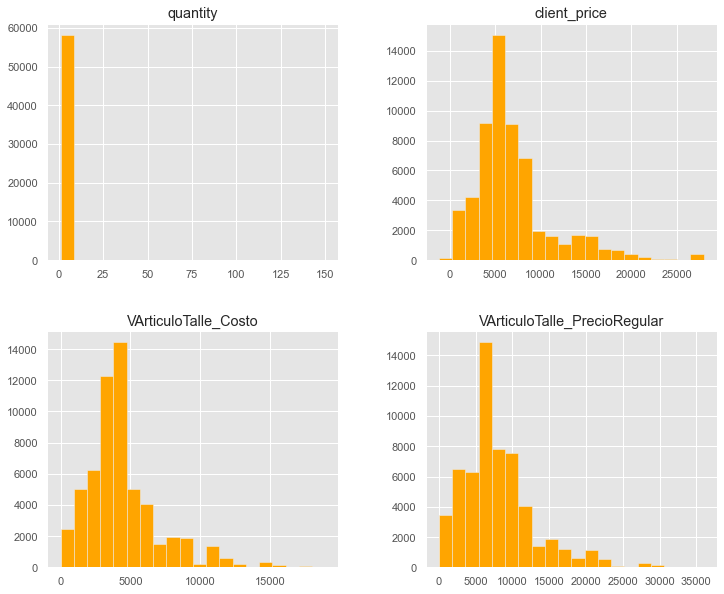

In [100]:
# Histogramas de variables cuantitativas
df.hist(figsize=(12,10), color='orange', bins=20)
plt.show()

Se puede notar que client_price tiene valores negativos, lo cual no tiene sentido y constituye un error de carga en los datos.
Vamos a eliminar esos registros para que no afecten el análisis.

In [101]:
#Eliminamos los registros con precios negativos
df = df.drop(df[df['client_price'] < 0].index)
df[df['client_price'] < 0]

,ecomm_order_id,ecommerce,store,ecomm_creation_date_x,linea,marca,vArticulo_id,vTalle_Codigo,producto,quantity,client_price,VArticuloTalle_Costo,VArticuloTalle_PrecioRegular,ecomm_transporte_nombre,ColorPrimario,ProveedorId,Disciplina,Genero,sex,date_handling,date_invoiced,date_canceled,email,adress_id,latitude,longitude,payment,client_id


In [102]:
#Análisis particular de la variable "client_price"
variable = 'client_price'

minimo = df[variable].min()
maximo = df[variable].max()
media = df[variable].mean()
mediana = df[variable].median()
moda = df[variable].mode()[0]
stdev = df[variable].std()
varian = df[variable].var()

print('Minimo: ' + str(minimo))
print('Maximo: ' + str(maximo))
print('Media: ' + str(round(media,2)))
print('Mediana: ' + str(mediana))
print('Moda: ' + str(moda))
print('Desviación estándar: ' + str(round(stdev,2)))
print('Varianza: ' + str(round(varian,2)))

Minimo: 0.0
Maximo: 27999.0
Media: 6886.61
Mediana: 5999.0
Moda: 5999.0
Desviación estándar: 4315.69
Varianza: 18625177.46


<Figure size 720x648 with 0 Axes>

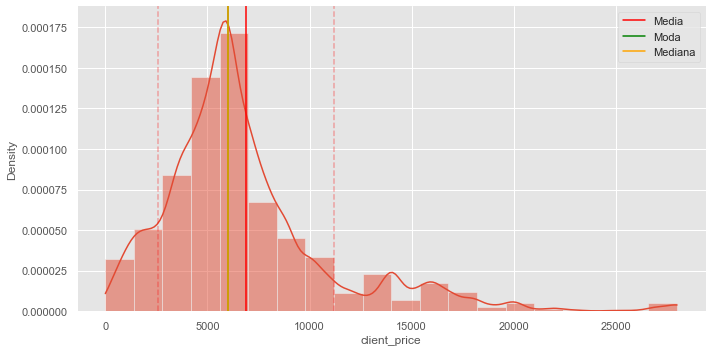

In [103]:
#Histograma y curva de densidad de client_price con media, mediana y moda
plt.figure(figsize=(10, 9))
ax = sns.displot(data=df, 
                 x = variable, 
                 kde=True,
                stat="density",
                height=5,
                aspect=2,
                bins = 20)

plt.axvline(media,
           color = "red",
           label = 'Media')

plt.axvline(media - stdev,
           color = "red",
           alpha = 0.3,
           linestyle = "--")

plt.axvline(media + stdev,
           color = "red",
           alpha = 0.3,
           linestyle = "--")

plt.axvline(moda,
           color = "green",
           alpha = 1,
           label = 'Moda')

plt.axvline(mediana,
           color = "orange",
           alpha = 1,
           label = 'Mediana')

plt.legend()

plt.show()

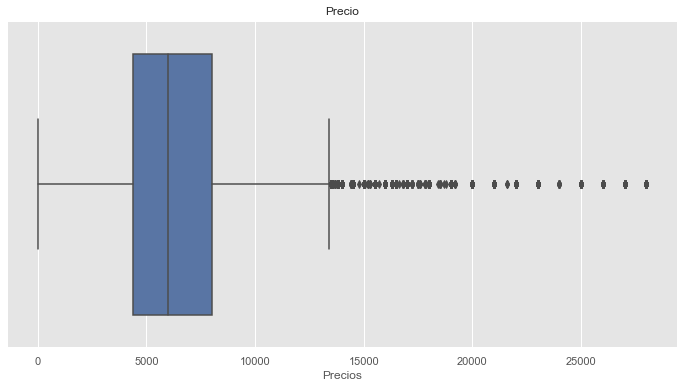

In [104]:
#Boxplot para client_price
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df['client_price'])
plt.title('Precio')
plt.xlabel('Precios')
plt.show()

In [105]:
#Análisis particular de la variable "VArticuloTalle_Costo"
variable = 'VArticuloTalle_Costo'

minimo = df[variable].min()
maximo = df[variable].max()
media = df[variable].mean()
mediana = df[variable].median()
moda = df[variable].mode()[0]
stdev = df[variable].std()
varian = df[variable].var()

print('Minimo: ' + str(minimo))
print('Maximo: ' + str(maximo))
print('Media: ' + str(round(media,2)))
print('Mediana: ' + str(mediana))
print('Moda: ' + str(moda))
print('Desviación estándar: ' + str(round(stdev,2)))
print('Varianza: ' + str(round(varian,2)))

Minimo: 0.1
Maximo: 18946.84
Media: 4434.43
Mediana: 4024.3641
Moda: 3452.13
Desviación estándar: 2627.74
Varianza: 6905003.74


<Figure size 720x648 with 0 Axes>

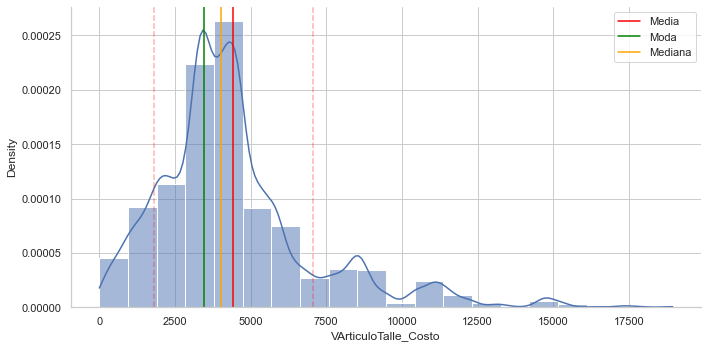

In [106]:
#Histograma y curva de densidad de VArticuloTalle_Costo con media, mediana y moda
plt.figure(figsize=(10, 9))
ax = sns.displot(data=df, 
                 x = variable, 
                 kde=True,
                stat="density",
                height=5,
                aspect=2,
                bins=20)

plt.axvline(media,
           color = "red",
           label = 'Media')

plt.axvline(media - stdev,
           color = "red",
           alpha = 0.3,
           linestyle = "--")

plt.axvline(media + stdev,
           color = "red",
           alpha = 0.3,
           linestyle = "--")

plt.axvline(moda,
           color = "green",
           alpha = 1,
           label = 'Moda')

plt.axvline(mediana,
           color = "orange",
           alpha = 1,
           label = 'Mediana')

plt.legend()

plt.show()

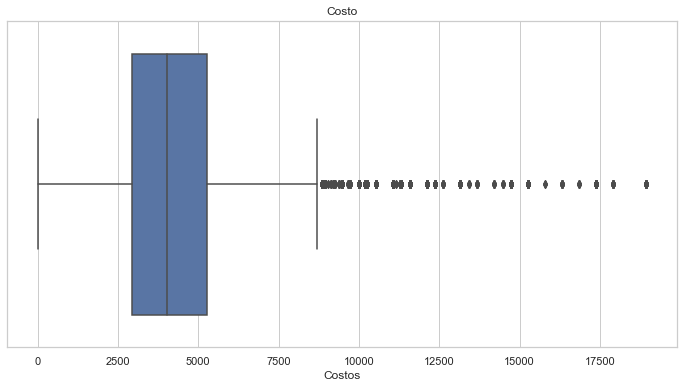

In [107]:
#Boxplot para VArticuloTalle_Costo
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df['VArticuloTalle_Costo'])
plt.title('Costo')
plt.xlabel('Costos')
plt.show()

In [108]:
#Análisis de valores únicos de variables categóricas
cat_columns=['ecommerce', 'store', 'linea', 'marca','vTalle_Codigo','ecomm_transporte_nombre','ColorPrimario','Disciplina','Genero','payment','sex']

for i in cat_columns:
    print(df[i].name)
    print(df[i].unique())

ecommerce
['vtex' 'meli']
store
['Dash' 'Grid' 'Mark' 'Fila' 'Adidas Performance' 'Nike' 'Puma'
 'Rebook Argentina' 'Stadium' 'Adidas Original' 'Umbro']
linea
['INDUMENTARIA        ' 'CALZADO ADULTOS     ' 'ACCESORIOS-REPUESTOS'
 'MEDIAS              ' 'CALZADO NIÑOS       ' 'BOLSOS              ' nan]
marca
['ADIDAS FUTBOL       ' 'PUMA                ' 'NIKE                '
 'FILA DASS           ' 'ADIDAS ARGENTINAS   ' 'TOPPER              '
 'FOOTY MEILY         ' 'NEW BALANCE         ' 'JOHN FOOS ARGENTINA '
 'NIKE ANNEX          ' 'FALLEN              ' 'ATLETIC SERV SA     '
 'O´NEILL             ' 'REEBOK ARGENTINA    ' 'KLALUTEX            '
 'REVES               ' 'BESS II             ' 'CULTURA             '
 'SHOTER              ' 'UNDER ARMOUR        ' 'ZUMM                '
 'GOORIN              ' 'UMBRO DASS          ' 'SPORT COMPLEMENTS   '
 'JAGUAR              ' 'NUEVO EMPORIO       ' 'ASICS ARGENTINA     '
 'JANSPORT            ' 'NIKEGOLF            ' nan 'KONNA   

In [109]:
#Normalización de datos de variables categóricas

#linea: quitamos los espacios y reemplazamos los NaN por "DESCONOCIDO"
df['linea'] = df['linea'].str.strip()
df['linea'] = df['linea'].fillna('DESCONOCIDA')

#marca: quitamos los espacios y reemplazamos los NaN por "DESCONOCIDA"
df['marca'] = df['marca'].str.strip()
df['marca'] = df['marca'].fillna('DESCONOCIDA')

#ecomm_transporte_nombre: quitamos espacios y unificamos los que significan lo mismo
df['ecomm_transporte_nombre'] = df['ecomm_transporte_nombre'].str.strip()
df['ecomm_transporte_nombre'] = df['ecomm_transporte_nombre'].replace(to_replace =["Estándar a domicilio", "Normal a domicilio"], value ="Envio a domicilio Estándar")
df['ecomm_transporte_nombre'] = df['ecomm_transporte_nombre'].replace(to_replace =["Transporte interno Essential Meli"], value ="Transporte interno Essential")
df['ecomm_transporte_nombre'] = df['ecomm_transporte_nombre'].replace(to_replace =["Express a domicilio", "Envio-24hs"], value ="Prioritario a domicilio")

#ColorPrimario: quitamos los espacios y reemplazamos los NaN por "DESCONOCIDO"
df['ColorPrimario'] = df['ColorPrimario'].str.strip()
df['ColorPrimario'] = df['ColorPrimario'].fillna('DESCONOCIDO')

#Disciplina: quitamos espacios, reemplazamos NaN por "DESCONOCIDA" y unificamos los que significan lo mismo
df['Disciplina'] = df['Disciplina'].str.strip()
df['Disciplina'] = df['Disciplina'].fillna('DESCONOCIDA')
df['Disciplina'] = df['Disciplina'].replace(to_replace =["TENNIS"], value ="TENIS")

#Genero: quitamos los espacios y reemplazamos los NaN por "DESCONOCIDO"
df['Genero'] = df['Genero'].str.strip()
df['Genero'] = df['Genero'].fillna('DESCONOCIDO')

#payment: unificamos los que significan lo mismo y reemplazamos '\\N' por "Desconocido"
df = df.replace({"creditCard": "credit_card","account_money": "MercadoPago", "\\N":"Desconocido"})

#sex: reemplazamos NaN por "Desconocido"
df['sex'] = df['sex'].fillna('DESCONOCIDO')


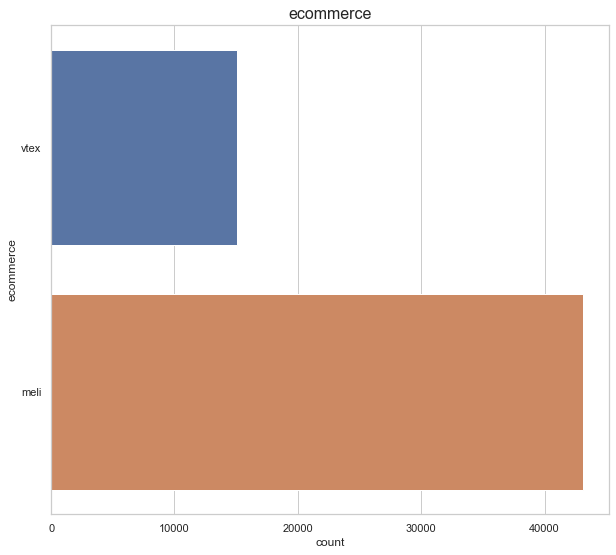

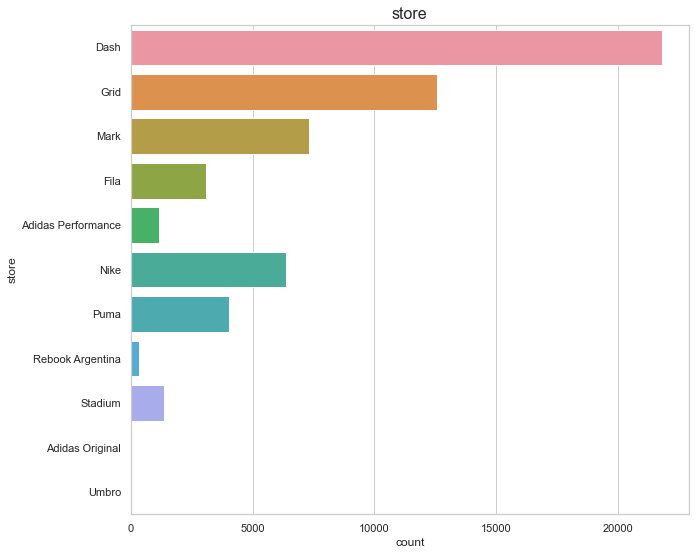

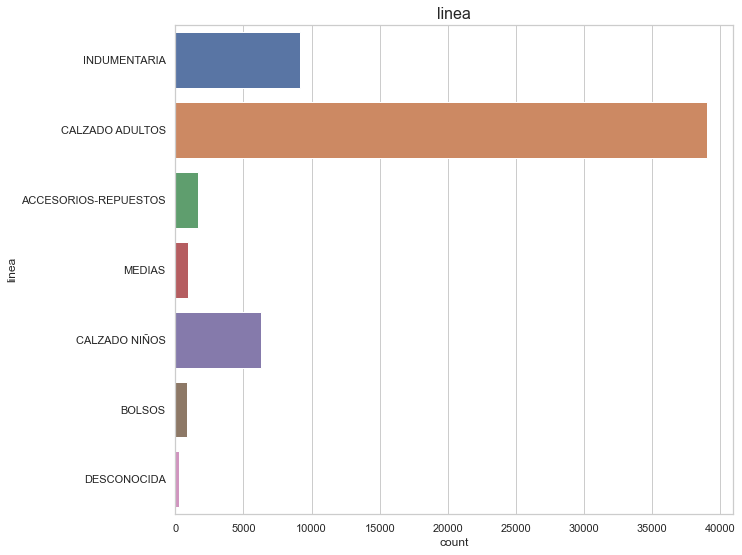

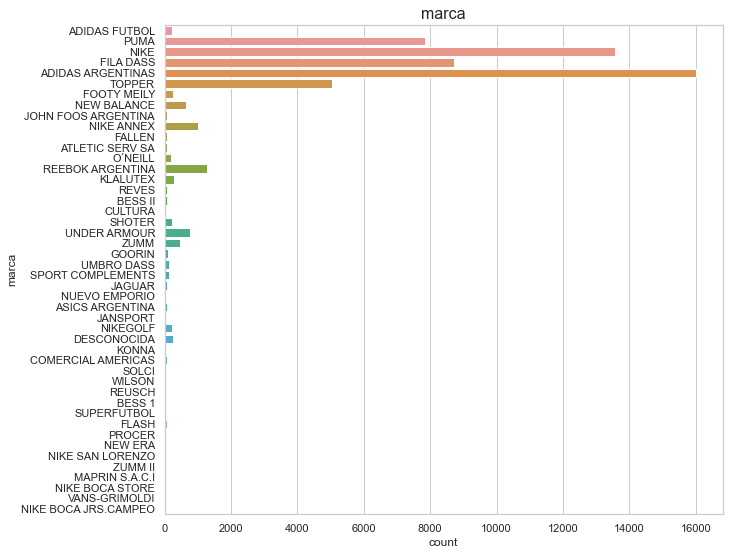

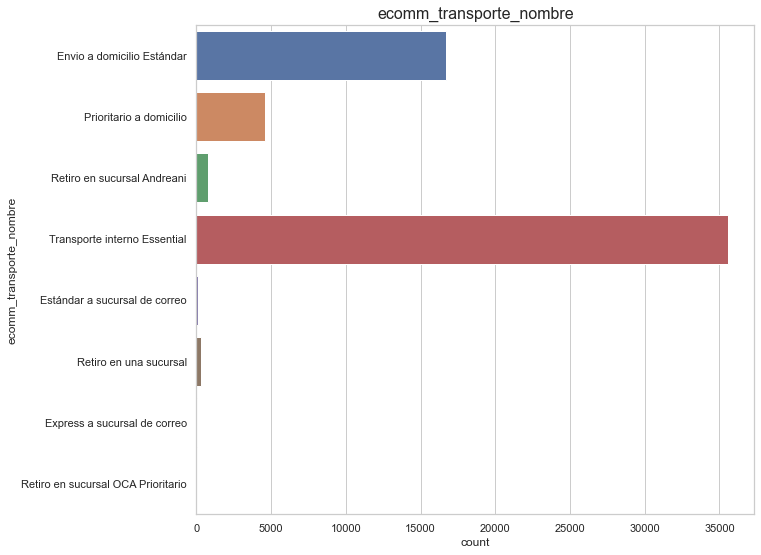

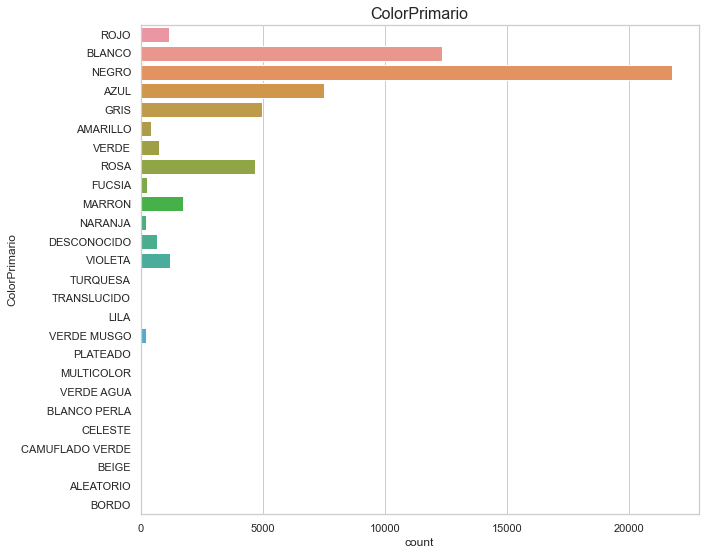

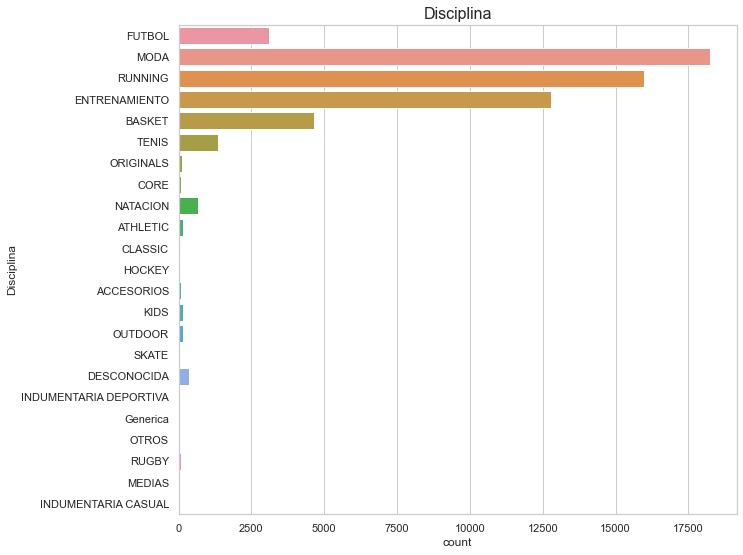

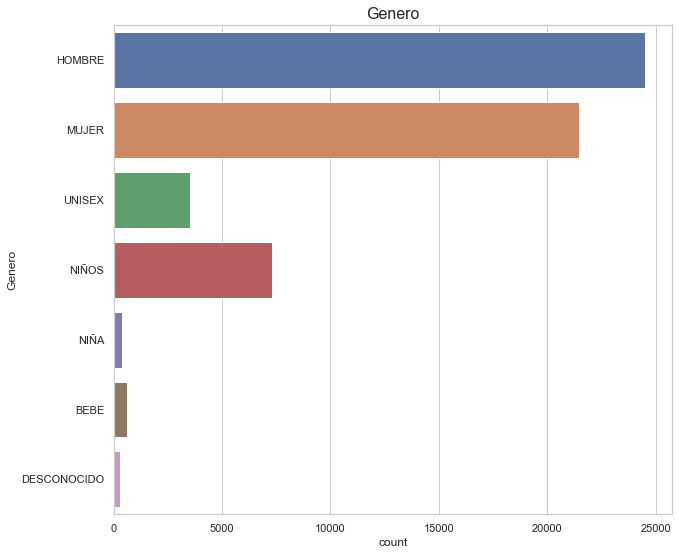

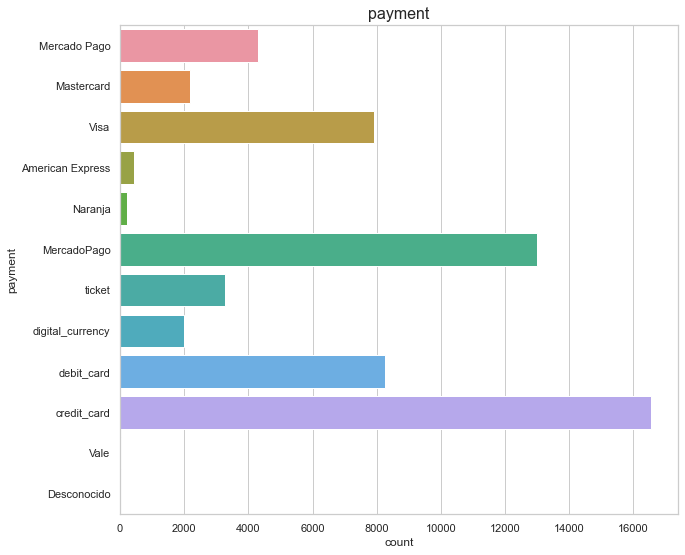

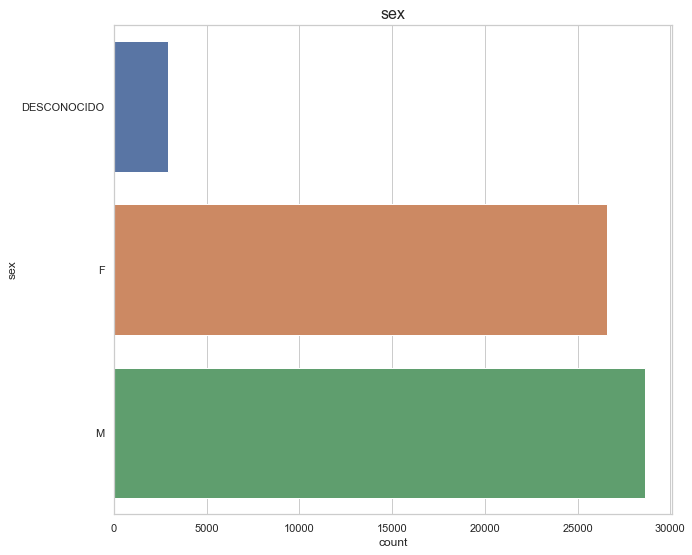

In [110]:
#Análisis de frecuencias de variables categóricas (excepto talle)
cat_columns=['ecommerce', 'store', 'linea', 'marca','ecomm_transporte_nombre','ColorPrimario','Disciplina','Genero','payment','sex']

for i in cat_columns:
    df[i] = df[i].str.rstrip()

for i in cat_columns:
    plt.figure(figsize=(10,9))
    plt.title(i,fontsize=16)
    plt.rcParams['figure.facecolor'] = 'White'
    sns.countplot(y=df[i])
    plt.show()

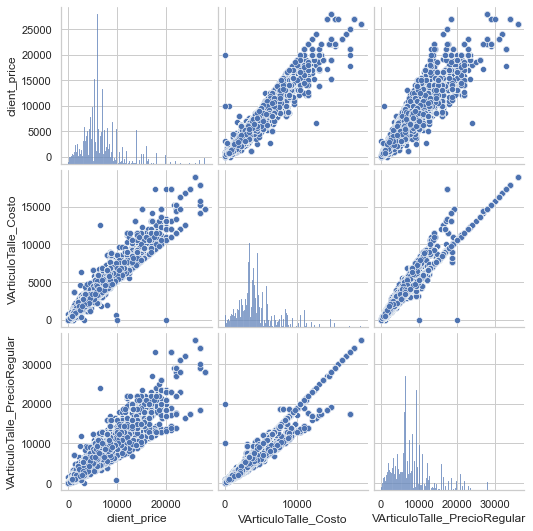

In [111]:
#Scatterplots para ver las relaciones entre todas las variables cuantitativas
sns.pairplot(df[['client_price','VArticuloTalle_Costo','VArticuloTalle_PrecioRegular']])
plt.show()

In [112]:
#Cálculo de la correlación entre variables
df.corr()

,quantity,client_price,VArticuloTalle_Costo,VArticuloTalle_PrecioRegular
quantity,1.000000,-0.027721,-0.031880,-0.029889
client_price,-0.027721,1.000000,0.958585,0.926105
VArticuloTalle_Costo,-0.031880,0.958585,1.000000,0.964889
VArticuloTalle_PrecioRegular,-0.029889,0.926105,0.964889,1.000000


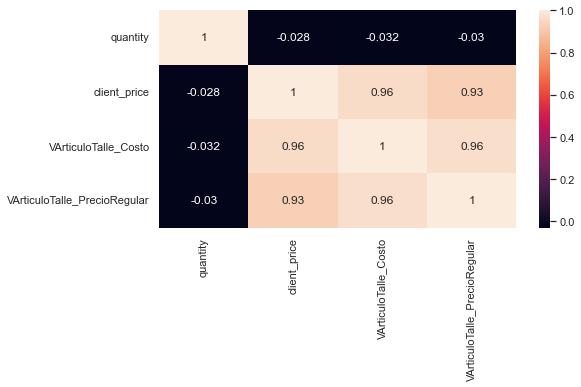

In [113]:
#Heatmap de la correlación
plt.subplots(figsize=(8, 4))
sns.heatmap(df.corr(),annot=True)
plt.show()

En base a los gráficos anteriores se puede notar que todas las variables de precio y costo están altamente correlacionadas positivamente (si una crece la otra también), lo cual tiene sentido ya que la ganancia se genera vendiendo a un precio superior al costo

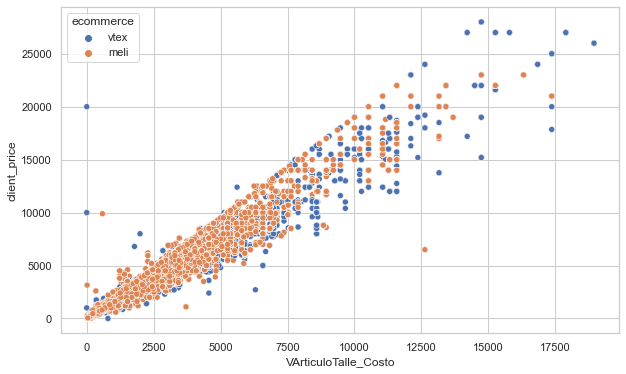

In [114]:
#Analizamos particularmente la relación entre el costo y el precio por ecommerce
plt.subplots(figsize=(10, 6))
sns.scatterplot(x='VArticuloTalle_Costo', y='client_price', hue='ecommerce', data=df)
plt.show()

Se puede notar que:

Para costos similares Meli en general vende a un mayor precio, por lo que es probable que genere mayor ganancia.
Hay algunos casos atípicos a analizar donde el costo es 0 y el artículo se vendió con un precio determinado.
Meli tiene mayor concentración de puntos en precios menores a 10000, por lo que es probable que genere mayor cantidad de ventas de productos en ese rango de precios.

In [115]:
#Agregamos la variable "ganancia" (precio - costo) para analizar algunas cuestiones en base a la misma
df["ganancia"] = df["client_price"] - df["VArticuloTalle_Costo"]
df[['client_price','VArticuloTalle_Costo','ganancia']]

,client_price,VArticuloTalle_Costo,ganancia
0,5439.2,4829.3400,609.8600
1,9499.0,6052.0000,3447.0000
2,3839.0,3315.2600,523.7400
3,799.0,526.6000,272.4000
4,8999.0,5365.9976,3633.0024
...,...,...,...
58164,5490.0,3452.1300,2037.8700
58165,2999.0,2833.6900,165.3100
58166,8999.0,4736.3200,4262.6800
58167,6319.0,4037.2300,2281.7700


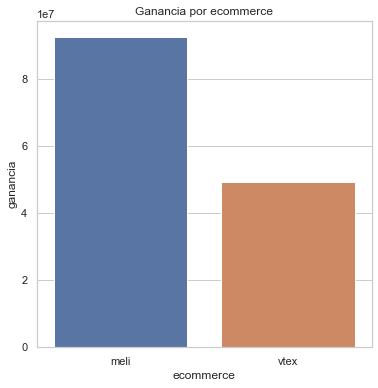

In [116]:
#Vemos cantidad de ventas y ganancia por ecommerce
cat = df[["ecommerce", "ganancia"]].groupby(['ecommerce'], as_index=False).sum().sort_values(by='ganancia', ascending=False)
plt.figure(figsize=(6,6))
sns.set_theme(style="whitegrid")
sns.barplot(x='ecommerce', y='ganancia', data=cat)
plt.title('Ganancia por ecommerce')
plt.show()

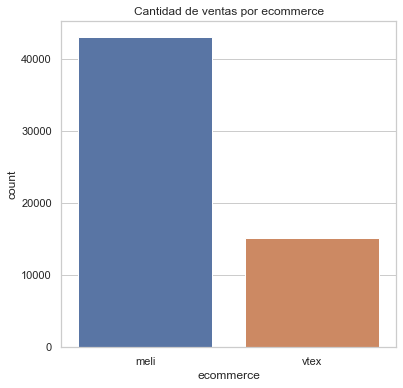

In [117]:
plt.figure(figsize=(6,6))
sns.set_theme(style="whitegrid")
sns.countplot(x = 'ecommerce',
              data = df,
              order = df['ecommerce'].value_counts().index)
plt.title('Cantidad de ventas por ecommerce')
plt.show()

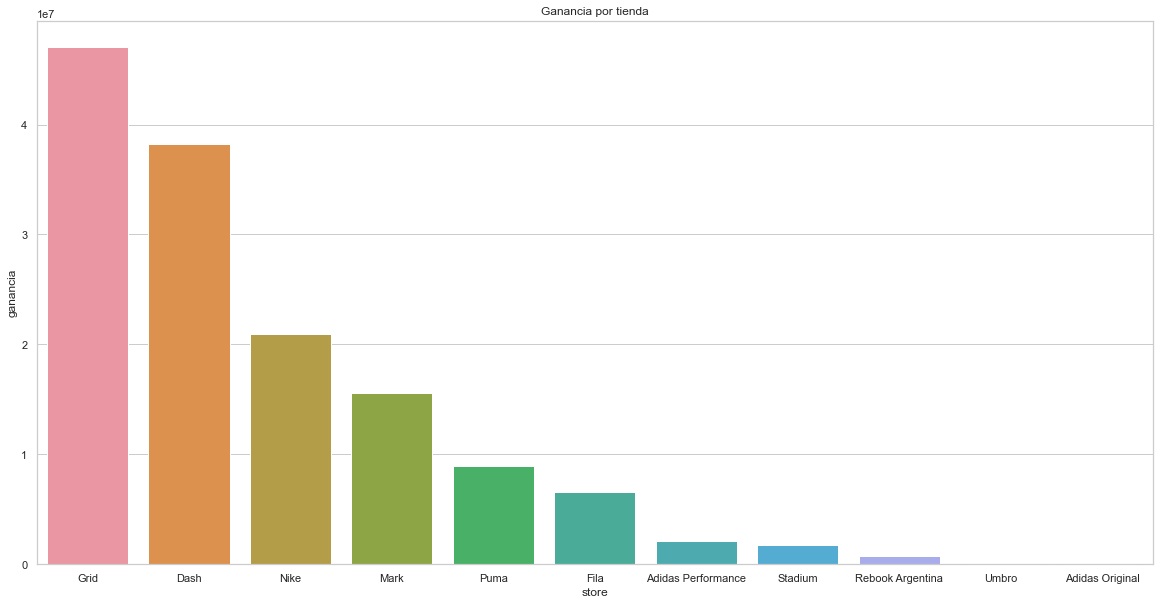

In [118]:
#Analizamos las ganancias por tienda
cat = df[["store", "ganancia"]].groupby(['store'], as_index=False).sum().sort_values(by='ganancia', ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x='store', y='ganancia', data=cat)
plt.title('Ganancia por tienda')
plt.show()

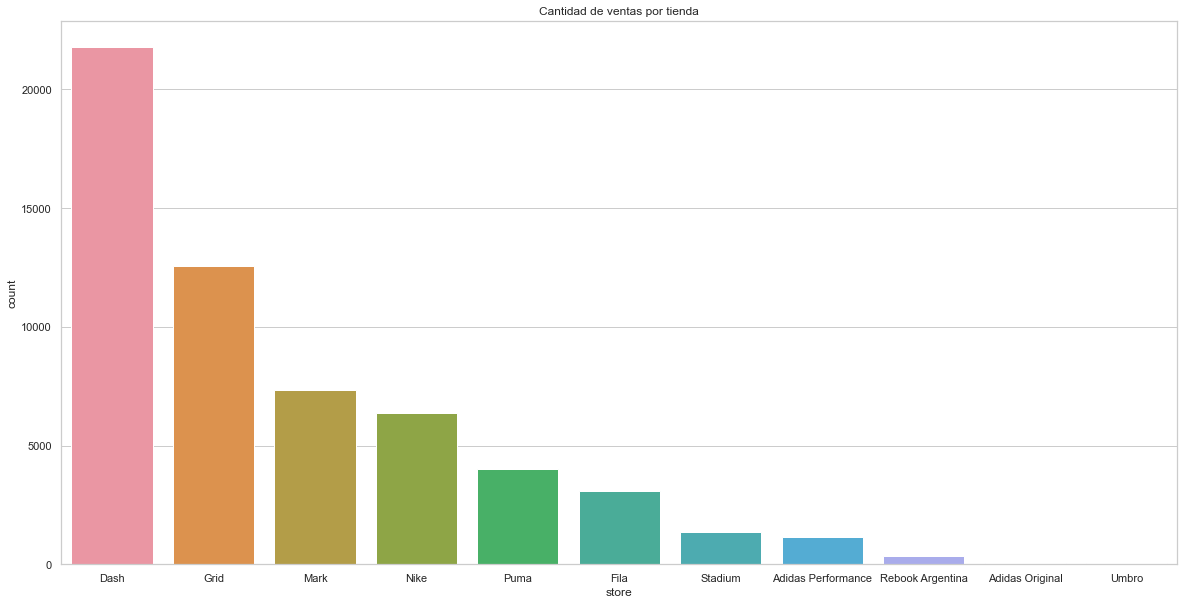

In [119]:
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
sns.countplot(x = 'store',
              data = df,
              order = df['store'].value_counts().index)
plt.title('Cantidad de ventas por tienda')
plt.show()

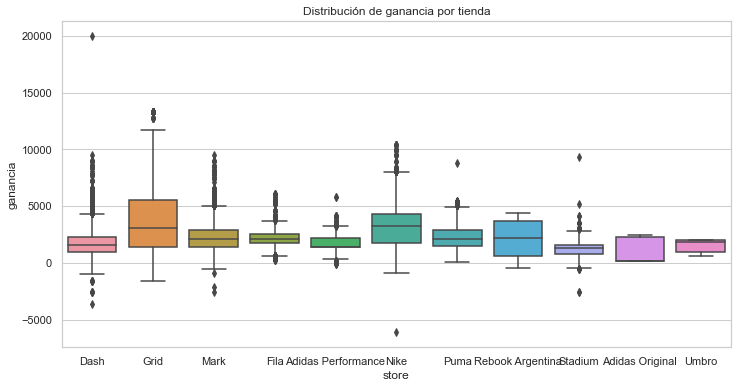

In [120]:
plt.subplots(figsize=(12, 6))
sns.boxplot(x=df['store'], y=df['ganancia'])
plt.title('Distribución de ganancia por tienda')
plt.show()

In [121]:
df[df['ganancia'] < -5000]

,ecomm_order_id,ecommerce,store,ecomm_creation_date_x,linea,marca,vArticulo_id,vTalle_Codigo,producto,quantity,client_price,VArticuloTalle_Costo,VArticuloTalle_PrecioRegular,ecomm_transporte_nombre,ColorPrimario,ProveedorId,Disciplina,Genero,sex,date_handling,date_invoiced,date_canceled,email,adress_id,latitude,longitude,payment,client_id,ganancia
43180,4333678921,meli,Nike,29/1/2021 02:14,CALZADO ADULTOS,NIKE,306-5639,09 *,Botines Nike Tiempo Legend 8 Pro Fg Hombre,1,6499.0,12631.05,23999.0,Transporte interno Essential,NEGRO,AT6133-004,FUTBOL,HOMBRE,M,Desconocido,29/1/2021 09:25,Desconocido,ttincho.61zfk1r+2-ogqztgmzwg44dsnrx@mail.merca...,Desconocido,Desconocido,Desconocido,digital_currency,81e7601002a411dc674f1219170eaf33,-6132.05


Se puede notar que:

La tienda "Grid" es la que mayor ganancia genera.
La segunda que mayor ganancia genera es "Dash", pero de acuerdo al boxplot tiene en promedio ganancias menores a varias de las tiendas y algunos outliers a analizar. También es la que mayor cantidad de ventas tiene.Ambas tienen pérdidas probablemente por las promociones que ofrecen.
"Nike" tiene un caso de pérdida mayor a 5000 que habría que analizar en detalle para ver si corresponde a un error de datos o hubo realmente una venta con esa pérdida.

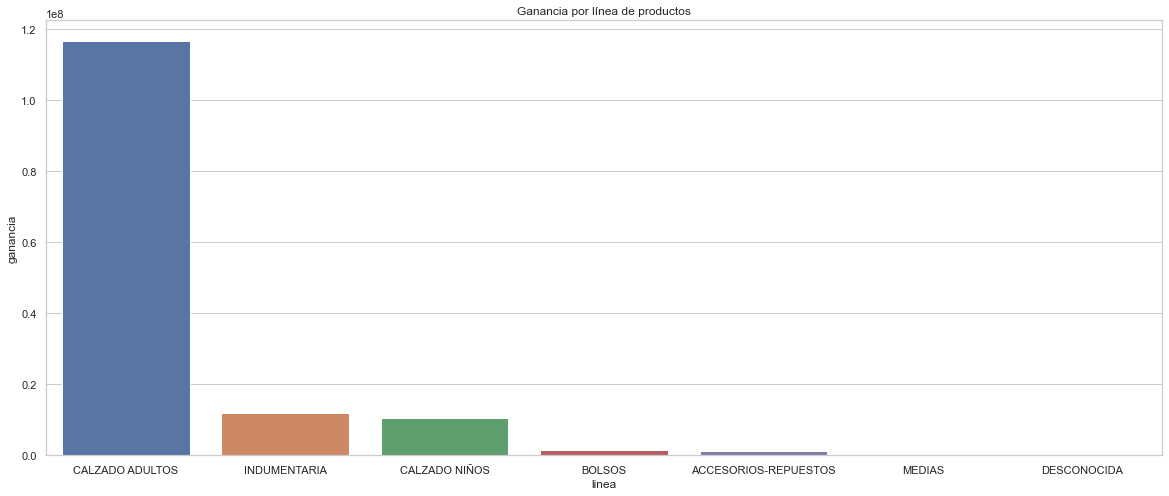

In [122]:
#Analizamos las ganancias por línea de producto
cat = df[["linea", "ganancia"]].groupby(['linea'], as_index=False).sum().sort_values(by='ganancia', ascending=False)
plt.figure(figsize=(20,8))
sns.barplot(x='linea', y='ganancia', data=cat)
plt.title('Ganancia por línea de productos')
plt.show()

In [123]:
#Análisis de ventas género vs tienda
pd.crosstab(df.Genero, df.store, normalize='columns')

store,Adidas Original,Adidas Performance,Dash,Fila,Grid,Mark,Nike,Puma,Rebook Argentina,Stadium,Umbro
Genero,,,,,,,,,,,
BEBE,0.000000,0.006076,0.010456,0.000000,0.012958,0.008725,0.014611,0.018431,0.000000,0.000000,0.000000
DESCONOCIDO,0.000000,0.004340,0.008714,0.000000,0.002226,0.004499,0.000314,0.005978,0.002941,0.002191,0.018182
HOMBRE,0.491803,0.221354,0.359826,0.437075,0.490421,0.519973,0.383346,0.499128,0.526471,0.293645,0.672727
MUJER,0.508197,0.629340,0.384499,0.500485,0.287066,0.324472,0.372506,0.428394,0.441176,0.408327,0.000000
NIÑA,0.000000,0.000868,0.011190,0.000000,0.001351,0.002181,0.011940,0.001245,0.000000,0.021914,0.000000
NIÑOS,0.000000,0.074653,0.151571,0.057263,0.133715,0.079891,0.162294,0.039352,0.017647,0.199416,0.272727
UNISEX,0.000000,0.063368,0.073745,0.005176,0.072263,0.060259,0.054988,0.007472,0.011765,0.074507,0.036364


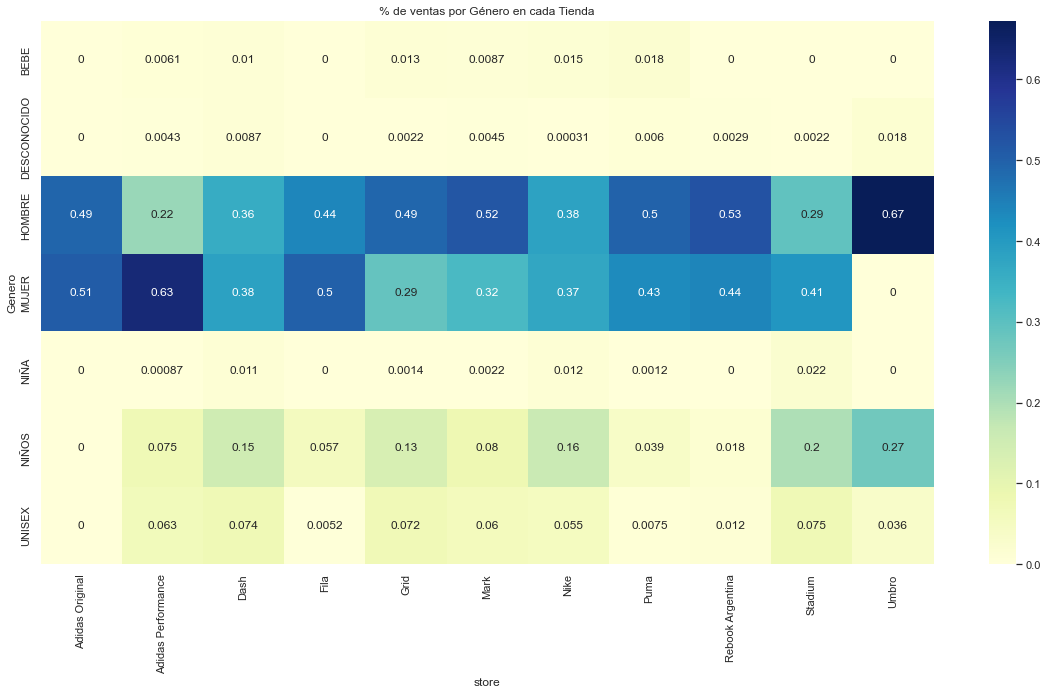

In [124]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df.Genero, df.store, normalize='columns'),
            cmap="YlGnBu", annot=True)
plt.title('% de ventas por Género en cada Tienda')
plt.show()

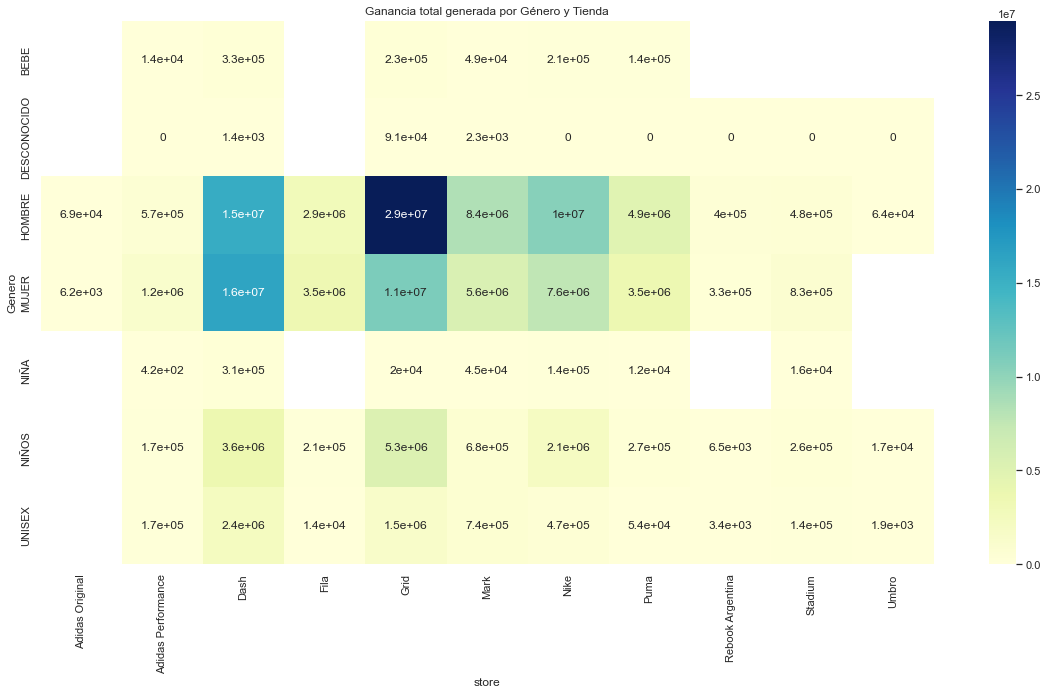

In [125]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.crosstab(df.Genero, df.store, values=df.ganancia, aggfunc='sum').round(0),cmap="YlGnBu", annot=True)
plt.title('Ganancia total generada por Género y Tienda')
plt.show()

Se puede notar que:

Casi todas las tiendas venden mayoritariamente productos para hombre y mujer, a excepción de "Umbro" que tiene un 50% de ventas en productos para niños.
La mayor ganancia la genera la tienda "Grid" con artículos para hombres, seguida de "Dash" con artículos para hombres y mujeres.

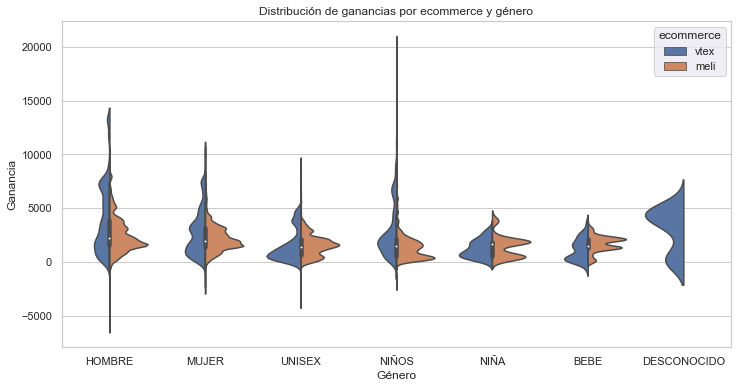

In [126]:
#Distribución de ganancias por ecommerce y género
fig, ax = plt.subplots(figsize=(12, 6))
sns.set()
ax = sns.violinplot(x='Genero', y='ganancia', hue='ecommerce',data=df, split=True)
ax.set(ylabel='Ganancia', xlabel='Género', title='Distribución de ganancias por ecommerce y género')
plt.show()

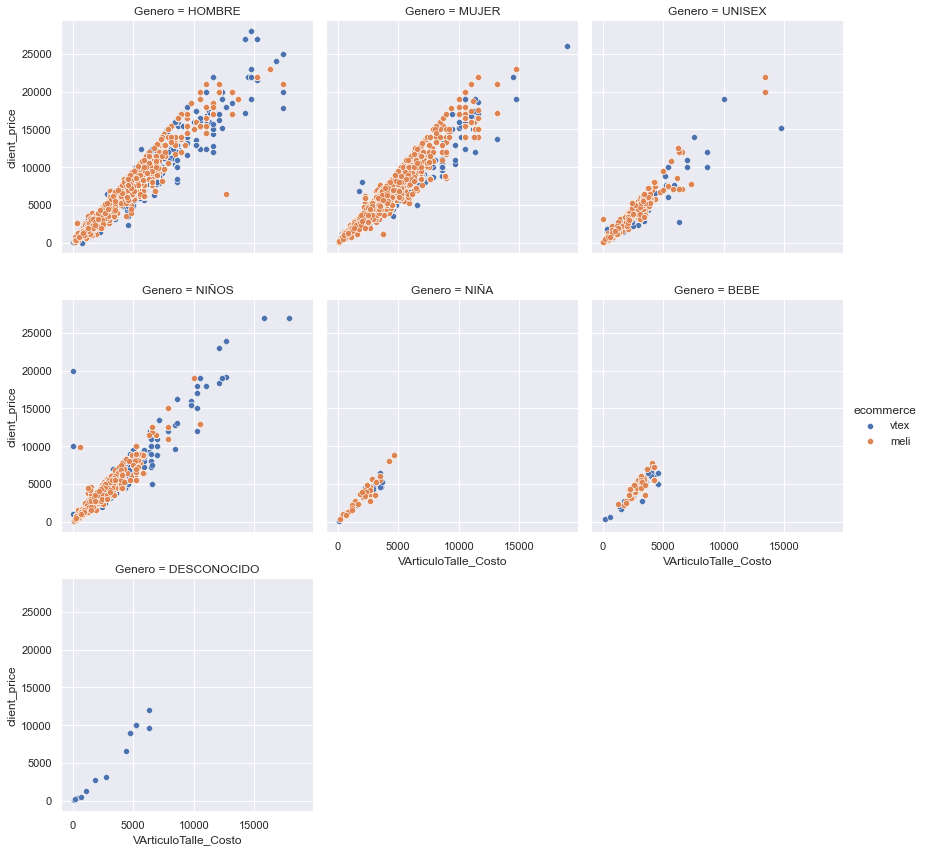

In [127]:
#Scatterplot precio y costo dividido por cada género y por ecommerce 
g = sns.FacetGrid(df, col="Genero",  hue="ecommerce", height=4, col_wrap=3)
g.map(sns.scatterplot, "VArticuloTalle_Costo", "client_price")
g.add_legend()
plt.show()

In [128]:
#Análisis de cantidad vendida y ganancia por disciplina
df_disciplina = pd.DataFrame(df.groupby('Disciplina').sum())[['quantity', 'ganancia']]
df_disciplina

,quantity,ganancia
Disciplina,,
ACCESORIOS,98,5.409630e+04
ATHLETIC,166,9.009943e+04
BASKET,4679,2.925274e+07
CLASSIC,63,2.917295e+04
CORE,83,2.337025e+05
DESCONOCIDA,350,1.461754e+05
ENTRENAMIENTO,12982,2.328932e+07
FUTBOL,3241,5.514999e+06
Generica,20,8.020800e+03


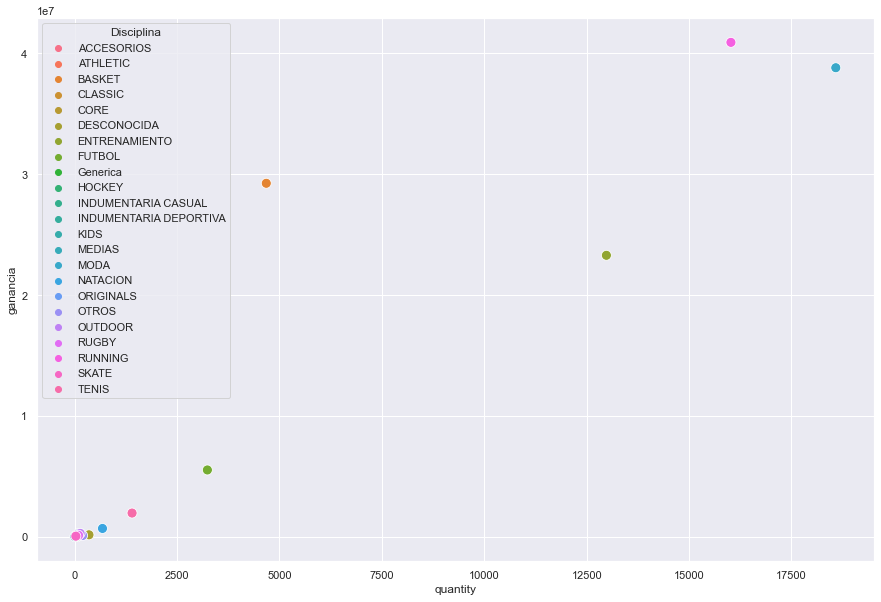

In [129]:
plt.subplots(figsize=(15, 10))
sns.scatterplot(x='quantity', y='ganancia', hue=df_disciplina.index, data=df_disciplina, s=100)
plt.show()

In [130]:
#Análisis de componentes principales para cada disciplina usando las variables cuantitativas
df_store = pd.DataFrame(df.groupby('Disciplina').sum())[['quantity','client_price','VArticuloTalle_Costo','VArticuloTalle_PrecioRegular']]
df_store

,quantity,client_price,VArticuloTalle_Costo,VArticuloTalle_PrecioRegular
Disciplina,,,,
ACCESORIOS,98,1.364189e+05,8.232260e+04,1.633620e+05
ATHLETIC,166,2.941149e+05,2.040155e+05,3.254070e+05
BASKET,4679,7.228745e+07,4.303471e+07,8.000871e+07
CLASSIC,63,9.778160e+04,6.860865e+04,1.184760e+05
CORE,83,5.944084e+05,3.607059e+05,5.322170e+05
DESCONOCIDA,350,1.998654e+06,1.607976e+05,2.664330e+05
ENTRENAMIENTO,12982,6.483028e+07,4.154096e+07,7.547278e+07
FUTBOL,3241,1.495601e+07,9.442217e+06,1.623967e+07
Generica,20,3.468400e+04,2.666320e+04,4.989900e+04


In [131]:
# Entrenamiento modelo PCA con escalado de los datos
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df_store)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']
pca_pipe.fit(df_store)

pd.DataFrame(
    data    = modelo_pca.components_,
    columns = df_store.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4']
)

,quantity,client_price,VArticuloTalle_Costo,VArticuloTalle_PrecioRegular
PC1,0.492682,0.502023,0.502922,0.502302
PC2,-0.867456,0.329531,0.221279,0.299942
PC3,-0.027903,-0.749734,0.127858,0.648670
PC4,0.063297,0.277996,-0.825686,0.486780


----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[9.85421312e-01 1.43560371e-02 1.47215967e-04 7.54348375e-05]


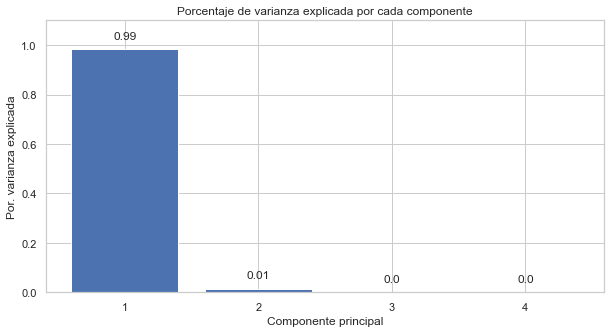

In [132]:
# Porcentaje de varianza explicada por cada componente
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)
import seaborn as sns
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df_store.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

In [133]:
# Proyección de las observaciones de entrenamiento
proyecciones = pca_pipe.transform(X=df_store)
proyecciones = pd.DataFrame(
    proyecciones,
    columns = ['PC1', 'PC2', 'PC3', 'PC4'],
    index   = df_store.index
)
proyecciones

,PC1,PC2,PC3,PC4
Disciplina,,,,
ACCESORIOS,-0.948281,-0.003333,0.004113,-0.001292
ATHLETIC,-0.935220,-0.010638,0.003647,-0.001697
BASKET,2.368491,0.892641,-0.051870,0.015924
CLASSIC,-0.952891,0.001558,0.004332,-0.002042
CORE,-0.932834,0.008595,0.001883,-0.003514
DESCONOCIDA,-0.896047,-0.025794,-0.034017,0.014517
ENTRENAMIENTO,2.945229,-0.573834,-0.018283,0.057114
FUTBOL,-0.055728,-0.174929,-0.020976,0.005567
Generica,-0.959476,0.007089,0.004580,-0.002350


Text(0, 0.5, 'PC2')

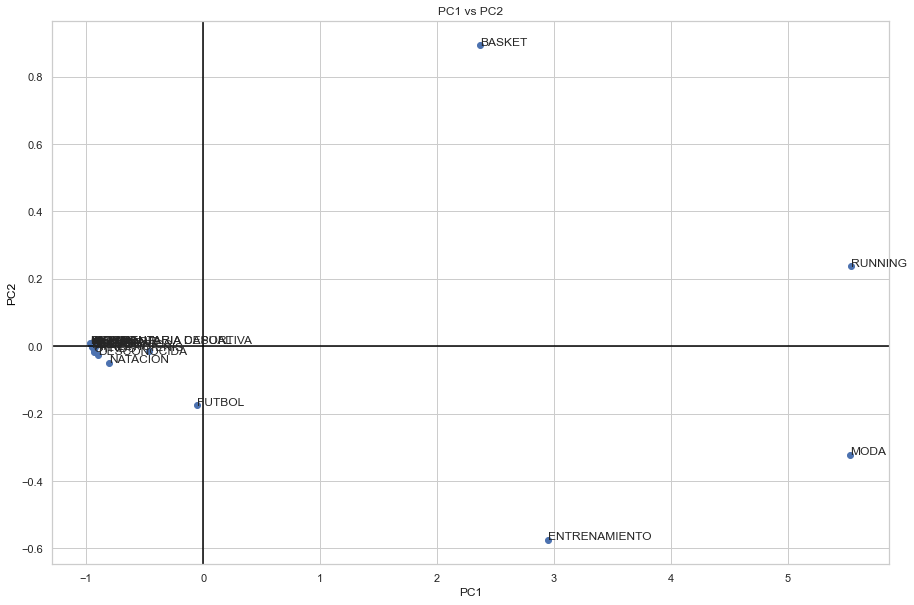

In [134]:
#Graficamos PC1 vs PC2 para ver relación entre disciplinas
from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))
proyecciones['val']=proyecciones.index

ax = proyecciones.set_index('PC1')['PC2'].plot(style='o')

def label_point(x, y, val, ax):
  a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
  for i, point in a.iterrows():
    ax.text(point['x'], point['y'], str(point['val']))

label_point(proyecciones.PC1, proyecciones.PC2, proyecciones.val, ax)
plt.axvline(x=0,color='black')
plt.axhline(y=0,color='black')
plt.title('PC1 vs PC2')
plt.xlabel('PC1',color='k')
plt.ylabel('PC2',color='black')

Utilizando el algoritmo k-means agruparemos a los clientes en clusters de acuerdo a dos variables:
- recurrencia de compra (cantidad de transacciones que realizaron)
- cantidad de dinero que gastaron (suma del precio de los productos que adquirieron)

In [359]:
from sklearn.cluster import KMeans #importamos la librería

#Armamos un dataset filtrado con los datos que necesitamos, eliminando los registros con precio nulo
df_k = df.dropna(subset=['client_price']).groupby('client_id')['client_price'].agg(spent ='sum', transactions= 'count')
df_k.sort_values(by='transactions', ascending=False).head()

,spent,transactions
client_id,,
7527b6831f0f7b7af3cf7c94e44a41ee,464084.2,92
110179867ac351769fb6f665d4d722e0,1233950.0,50
e533ff4a6c8c37c563d1193bf235879d,67641.0,34
cf6a5d84c021d54378f8cd7a31f5c06b,129914.6,29
56aed2cf4b30a7ea7ff39d0fce951ef2,110503.0,27


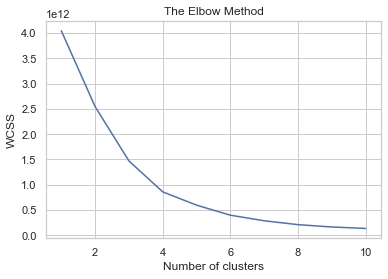

In [360]:
#Aplicamos el elbow method para encontrar el número óptimo de clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_k)
    wcss.append(kmeans.inertia_)

# Gráfica de la suma de las distancias
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

De acuerdo al gráfico obtenido con el Elbow Method determinamos que lo óptimo es armar 4 clústers

In [361]:
#Creamos el k-Means con 4 grupos / clústers
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 47) 
y_kmeans = kmeans.fit_predict(df_k)

In [362]:
#Agregamos la columna del clúster (pred) que determinó el algoritmo para cada registro
df_k['pred']=y_kmeans
df_k.sort_values(by='transactions', ascending=False)

,spent,transactions,pred
client_id,,,
7527b6831f0f7b7af3cf7c94e44a41ee,464084.2,92,2
110179867ac351769fb6f665d4d722e0,1233950.0,50,1
e533ff4a6c8c37c563d1193bf235879d,67641.0,34,2
cf6a5d84c021d54378f8cd7a31f5c06b,129914.6,29,2
56aed2cf4b30a7ea7ff39d0fce951ef2,110503.0,27,2
...,...,...,...
5c56bdafcdf25458f8b22df032f02e28,6999.0,1,0
5c577249b9e899180d1bf34f8883fb70,4399.0,1,0
5c59ea8bc542882ea130735c72bf10c2,1599.0,1,0


In [363]:
#Analizamos los promedios para cada grupo
df_k.groupby(['pred']).mean().round()

,spent,transactions
pred,,
0,6195.0,1.0
1,1233950.0,50.0
2,70302.0,6.0
3,16927.0,2.0


In [364]:
#Vemos la cantidad de clientes que quedó en cada grupo
df_k['pred'].value_counts()

0    37959
3     8756
2      226
1        1
Name: pred, dtype: int64

En conclusión:
- El grupo 0 contiene la mayor cantidad de clientes, que solo compraron 1 vez y gastaron poco
- El grupo 1 contiene un único cliente que compró 50 veces y gastó mucha cantidad de dinero. Se debería
analizar si corresponde a un error o es algún cliente especial
- El grupo 2 contiene clientes recurrentes que gastan montos considerables de dinero
- El grupo 3 contiene clientes que compran esporádicamente o compraron una vez pero gastaron más que la mayoría

Ahora vamos a elegir un algoritmo de clasificación para predecir cuál es el mejor ecommerce (vtex o meli) para publicar un artículo y aumentar las chances de que se venda en base a su precio, la tienda y la línea del producto

In [372]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier #Árbol de decisión
from sklearn.ensemble import RandomForestClassifier #Random forest
from sklearn.neighbors import KNeighborsClassifier #knn
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.metrics import accuracy_score #para calcular precisión de modelos

In [366]:
#Creamos un dataset reducido con los datos que vamos a utilizar para los algoritmos
df2 = df[['client_price','store','linea', 'ecommerce']]

#Validamos la cantidad de datos no nulos
df2.count()

client_price    58156
store           58167
linea           58167
ecommerce       58167
dtype: int64

In [367]:
#Normalizamos los datos
#linea: quitamos los espacios y remplazamos los NaN por "DESCONOCIDA"
df2['linea'] = df2['linea'].str.strip()
df2['linea'] = df2['linea'].fillna('DESCONOCIDA')

#client_price: reemplazamos los NaN por 0
df2['client_price'] = df2['client_price'].fillna(0)

#Validamos que no haya más NaN
df2.count()

client_price    58167
store           58167
linea           58167
ecommerce       58167
dtype: int64

In [368]:
#Aplicamos one hot encoding para convertir las variables categóricas
df_final = pd.get_dummies(df2, drop_first=True)
df_final

,client_price,store_Adidas Performance,store_Dash,store_Fila,store_Grid,store_Mark,store_Nike,store_Puma,store_Rebook Argentina,store_Stadium,store_Umbro,linea_BOLSOS,linea_CALZADO ADULTOS,linea_CALZADO NIÑOS,linea_DESCONOCIDA,linea_INDUMENTARIA,linea_MEDIAS,ecommerce_vtex
0,5439.2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,9499.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,3839.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,799.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
4,8999.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58164,5490.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
58165,2999.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
58166,8999.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
58167,6319.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [369]:
#Dado que la variable a predecir será el ecommerce, la eliminamos del dataset
X = df_final.drop("ecommerce_vtex", axis=1)
X

,client_price,store_Adidas Performance,store_Dash,store_Fila,store_Grid,store_Mark,store_Nike,store_Puma,store_Rebook Argentina,store_Stadium,store_Umbro,linea_BOLSOS,linea_CALZADO ADULTOS,linea_CALZADO NIÑOS,linea_DESCONOCIDA,linea_INDUMENTARIA,linea_MEDIAS
0,5439.2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,9499.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,3839.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,799.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,8999.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58164,5490.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
58165,2999.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
58166,8999.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
58167,6319.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [370]:
#Definimos la variable a predecir
y = df_final.ecommerce_vtex
y

0        1
1        1
2        1
3        1
4        1
        ..
58164    0
58165    0
58166    0
58167    0
58168    0
Name: ecommerce_vtex, Length: 58167, dtype: uint8

In [373]:
#Nos quedamos con 30% de datos para test y 70% para train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 

In [377]:
#Creamos distintos modelos para probar las predicciones y elegir uno

#KNN con n_neighbors=3
knn = KNeighborsClassifier(n_neighbors=3)

#Regresión logística
regresion_logistica = LogisticRegression()

#Random Forest con 200 árboles
random_forest = RandomForestClassifier(random_state=11, n_estimators=200)

In [378]:
#Entrenamos los modelos

knn.fit(X_train, y_train) #knn
regresion_logistica.fit(X_train, y_train) #regresion logistica
random_forest.fit(X_train, y_train) #random forest

RandomForestClassifier(n_estimators=200, random_state=11)

In [379]:
#Predicción de los modelos en train y test

#knn
y_train_pred_knn = knn.predict(X_train) 
y_test_pred_knn = knn.predict(X_test)

#regresion logistica
y_train_pred_regresion_logistica = regresion_logistica.predict(X_train) 
y_test_pred_regresion_logistica = regresion_logistica.predict(X_test)

#random forest
y_train_pred_random_forest = random_forest.predict(X_train) 
y_test_pred_random_forest = random_forest.predict(X_test)

In [384]:
#Calculamos el accuracy en Train y Test de todos los modelos
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)

print('KNN')
print('% de aciertos sobre el set de entrenamiento:', train_accuracy_knn)
print('% de aciertos sobre el set de evaluación:',test_accuracy_knn)
print('\n')

train_accuracy_regresion_logistica = accuracy_score(y_train, y_train_pred_regresion_logistica)
test_accuracy_regresion_logistica = accuracy_score(y_test, y_test_pred_regresion_logistica)

print('Regresión Logística')
print('% de aciertos sobre el set de entrenamiento:', train_accuracy_regresion_logistica)
print('% de aciertos sobre el set de evaluación:',test_accuracy_regresion_logistica)
print('\n')

train_accuracy_random_forest = accuracy_score(y_train, y_train_pred_random_forest)
test_accuracy_random_forest = accuracy_score(y_test, y_test_pred_random_forest)

print('Random Forest')
print('% de aciertos sobre el set de entrenamiento:', train_accuracy_random_forest)
print('% de aciertos sobre el set de evaluación:',test_accuracy_random_forest)

KNN
% de aciertos sobre el set de entrenamiento: 0.8936290401807643
% de aciertos sobre el set de evaluación: 0.8801214830095696


Regresión Logística
% de aciertos sobre el set de entrenamiento: 0.8652126927988997
% de aciertos sobre el set de evaluación: 0.861325998510114


Random Forest
% de aciertos sobre el set de entrenamiento: 0.9130317319972492
% de aciertos sobre el set de evaluación: 0.9014383129906596


Conclusión: De acuerdo al accuracy todos tienen similares valores entre train y test, pero el Random Forest alcanzó un 90% de precisión sobre el set de evaluación, por lo que es un muy buen modelo y el mejor a elegir para este caso

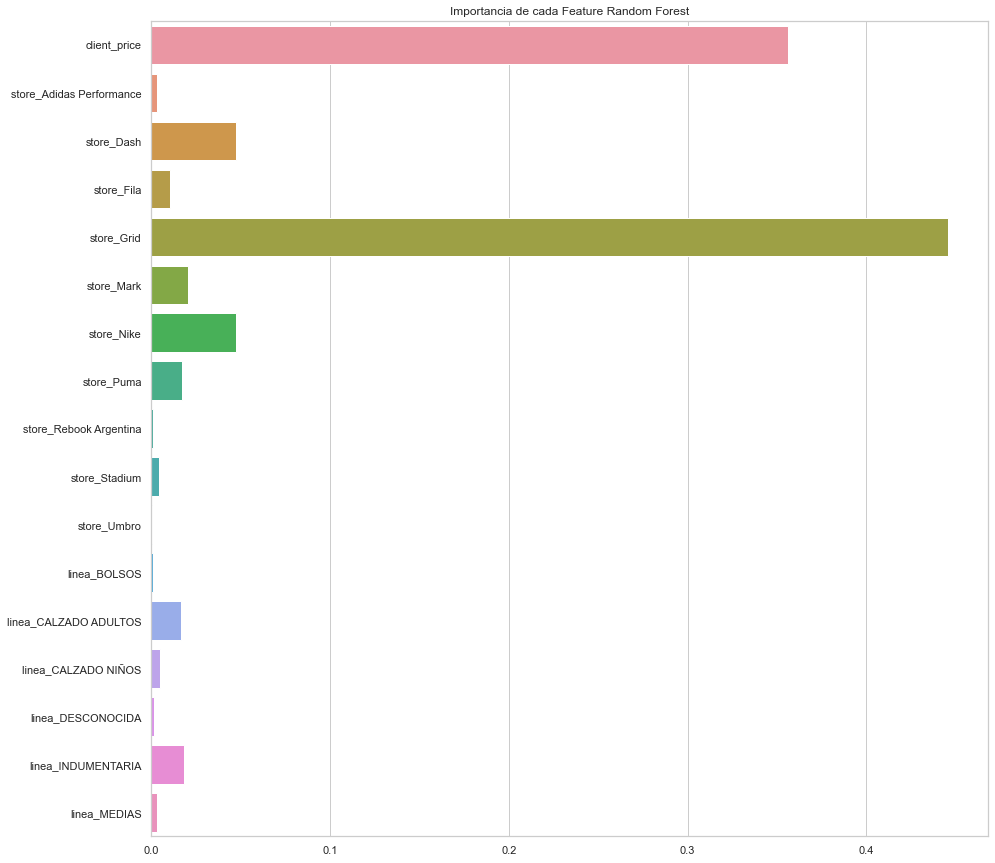

In [385]:
#Calculamos la importancia de las variables para el random forest

plt.figure(figsize=(15,15))
importances = random_forest.feature_importances_
columns = X.columns
sns.barplot(importances, columns)
plt.title('Importancia de cada Feature Random Forest')
plt.show()

Como se puede notar en el gráfico las variables que más peso tienen para el algoritmo son:
1. La tienda que vende el producto es Grid
2. El precio del producto
3. La tienda que vende el producto es Dash o Nike